In [118]:
import numpy as np
import xlrd #读取excel的库
Y=[] #先声明一个空list
data = xlrd.open_workbook(r'C:\Users\93631\Desktop\2020Himcm\mat\Y.xls') #读取文件
table = data.sheet_by_index(0) #按索引获取工作表，0就是工作表1
for i in range(table.nrows): #table.nrows表示总行数
    line=table.row_values(i) #读取每行数据，保存在line里面，line是list
    Y.append(line) #将line加入到resArray中，resArray是二维list
Y=np.array(Y) #将resArray从二维list变成数组

In [119]:
m,u=Y.shape
Y=Y/10

In [120]:
s=200
t=300#要扩充的职业数量和用户数量

In [121]:
new1=np.ones((31,t))*0
Y_1=np.append(Y,new1,axis=1)
Y_1=Y_1.transpose()
np.random.shuffle(Y_1)
Y_1=Y_1.transpose()
new2=np.ones((s,(t+u)))*0
Y_1=np.append(Y_1,new2,axis=0)
np.random.shuffle(Y_1)
Y=Y_1#把Y扩充为稀疏矩阵
Y.shape

(231, 326)

In [122]:
R=np.ones(Y.shape)*0
k=0
for i in range(0,Y.shape[0]):
    for j in range(0,Y.shape[1]):
        if Y[i][j]!=0:
            k=k+1
            R[i][j]=1
R.shape
k
#生成0-1矩阵R，1对应有评价的位置

703

In [123]:
Y1=Y
R1=R

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [126]:
#特征个数7
n_features = 7

In [127]:
def serialize(X, theta):
    return np.concatenate((X.ravel(), theta.ravel()))

def deserialize(params, n_job, n_user, n_features):
    return params[:n_job * n_features].reshape(n_job, n_features), \
           params[n_job * n_features:].reshape(n_user, n_features)
#代价函数
def cost(params, Y, R, n_features):
    n_job, n_user = Y.shape
    X, theta = deserialize(params, n_job, n_user, n_features)
    #注意这里只需要计算R=1的
    inner = np.multiply(X @ theta.T - Y, R)
    return np.power(inner, 2).sum() / 2
#梯度
def gradient(params, Y, R, n_features):
    n_job, n_user = Y.shape
    X, theta = deserialize(params, n_job, n_user, n_features)
    inner = np.multiply(X @ theta.T - Y, R)  # (231，326)
    X_grad = inner @ theta  #（231， 7）
    theta_grad = inner.T @ X  #（326，7）
    
    return serialize(X_grad, theta_grad)
#代价函数正规项
def regularized_cost(params, Y, R, n_features, lam=1):
    reg = np.power(params, 2).sum() * (lam / 2)
    return cost(params, Y, R, n_features) + reg
#梯度函数正规项
def regularized_gradient(params, Y, R, n_features, lam=1):
    grad = gradient(params, Y, R, n_features)
    reg = lam * params
    
    return grad + reg

In [128]:
#接下来给做过的或者评价过的工作打上分数（1-10分）
ratings = np.zeros((Y1.shape[0], 1))
ratings[0] = 7
ratings[6] = 8
ratings[11] = 3
ratings[53] = 7
ratings[110] = 5
ratings[65] = 2
ratings[134] = 6
ratings[97] = 6
ratings[182] = 4
ratings[225] = 5

In [129]:
#将新的评分添加到原来用户的评分集中
Y1 = np.append(Y1, ratings, axis=1)  
R1 = np.append(R1, ratings != 0, axis=1)
Y1.shape, R1.shape

((231, 327), (231, 327))

In [130]:
#初始化x和theta为较小随机数，同时进行标准化
n_features = 7
n_job, n_user = Y1.shape
lr = 10 #学习率
X = np.random.standard_normal((n_job, n_features))
theta = np.random.standard_normal((n_user, n_features))
#归一化
Y1_norm = Y1 - Y1.mean()
Y1_norm.mean()

2.7749329077039006e-18

In [131]:
#模型训练
import scipy.optimize as opt
params = np.concatenate((np.ravel(X), np.ravel(theta)))
res = opt.minimize(fun=regularized_cost,
                   x0=params,
                   args=(Y1_norm, R1, n_features, lr),
                   method='TNC',
                   jac=regularized_gradient)
res

     fun: 1738.6337674867723
     jac: array([ 1.97589347e-06,  6.74969779e-07, -6.41581252e-06, ...,
        1.65068137e-06,  5.51572435e-06,  1.01437688e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 281
     nit: 23
  status: 1
 success: True
       x: array([ 0.20966593, -0.16739969,  0.04095947, ..., -1.00921075,
       -2.40305395,  0.0562228 ])

In [132]:
#训练后的参数
X_trained, theta_trained = deserialize(res.x, n_job, n_user, n_features)
X_trained.shape, theta_trained.shape

((231, 7), (327, 7))

In [133]:
#进行预测
pred = X_trained @ theta_trained.T
final_preds = pred[:, -1] + Y1.mean()

In [134]:
idx=np.argsort(final_preds)[::-1]
idx

array([ 34, 151,  30, 123, 206,  95,  57, 196,   6, 112, 135,  33,  27,
       167, 137,  45,  11,   0,  53,  48, 160, 221,  62,  87, 155, 149,
       204, 175, 189, 103,  96, 217,  97, 134, 230, 225, 110,  10, 182,
        65,  91, 146, 194, 102, 121, 162, 179,  94,  46, 213, 108,  68,
       186, 143,  22, 220, 168,  50, 136, 205, 228, 226,   4,  71, 188,
       129, 125, 145, 216, 114,  55,  99, 124,  74,  32,  67,  18, 133,
       111,  17,  64,  78, 159,  79, 130, 166,   7,  85, 161,  51, 227,
       183,  98,  23, 229, 198, 172, 174, 105, 209,  77,  43, 122,  44,
         3, 201,   2, 158, 165, 104,  69,  15, 203, 120, 202, 132, 223,
       171, 152,  31, 128, 184,  54, 142, 219, 139, 169,  59,  28, 212,
        89, 100,  58, 177, 193, 191, 187, 199,  24,  83,   5, 140,  47,
       131,  73, 190, 195, 178, 208, 118,  20, 211,  35, 148, 153, 116,
       106,  39, 150,   1, 170,  60,  49, 107, 115,  70,  21, 157,  88,
       117, 126, 214, 176, 181, 113, 156, 197, 138,  82,  52,  6

In [135]:
job_num=[]
score=[]
for i in range(10):
    print('Predicting rating %0.1f for job number %s.' %(final_preds[idx[i]],idx[i]))
    job_num=np.append(job_num,'%d' %idx[i])
    score=np.append(score,final_preds[idx[i]])
job_num,score

Predicting rating 4.3 for job number 34.
Predicting rating 4.0 for job number 151.
Predicting rating 4.0 for job number 30.
Predicting rating 3.8 for job number 123.
Predicting rating 3.7 for job number 206.
Predicting rating 3.7 for job number 95.
Predicting rating 3.5 for job number 57.
Predicting rating 3.5 for job number 196.
Predicting rating 3.4 for job number 6.
Predicting rating 3.4 for job number 112.


(array(['34', '151', '30', '123', '206', '95', '57', '196', '6', '112'],
       dtype='<U32'),
 array([4.32067608, 4.02375908, 3.97817987, 3.78978267, 3.74186119,
        3.66659724, 3.53684865, 3.47586949, 3.40347834, 3.37752623]))

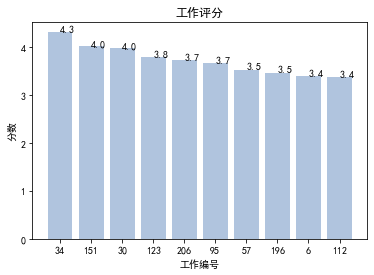

In [136]:
x_data=job_num
y_data=score
for i in range(0,10):
    plt.bar(x_data[i], y_data[i],color='lightsteelblue')
    plt.text(x_data[i], y_data[i],'%0.1f'%y_data[i])

# 正确显示中文和负号
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.title("工作评分")
plt.xlabel("工作编号")
plt.ylabel("分数")
# 显示
plt.show()

In [114]:
k=0
for i in range(0,Y.shape[0]):
    for j in range(0,Y.shape[1]):
        if Y[i][j]!=0:
            k=k+1
#扩充数据集
import random as rd
Y_2=Y
q=0
while q<500:
    i=rd.randint(0,Y.shape[0]-1)
    j=rd.randint(0,Y.shape[1]-1)
    if Y_2[i][j]==0:
        Y_2[i][j]=rd.randint(0,10)
    q+=1
q

500

In [115]:
k=0
R_2=np.ones(Y_2.shape)*0
for i in range(0,Y_2.shape[0]):
    for j in range(0,Y_2.shape[1]):
        if Y_2[i][j]!=0:
            R_2[i][j]=1
            k=k+1
k

1149

In [116]:
Y2=Y_2
R2=R_2
#接下来给做过的或者评价过的工作打上分数（1-10分）
ratings = np.zeros((Y2.shape[0], 1))
ratings[0] = 7
ratings[6] = 8
ratings[11] = 3
ratings[53] = 7
ratings[110] = 5
ratings[65] = 2
ratings[134] = 6
ratings[97] = 6
ratings[182] = 4
ratings[225] = 5
#将新的评分添加到原来用户的评分集中
Y2 = np.append(Y2, ratings, axis=1)  
R2 = np.append(R2, ratings != 0, axis=1)
Y2.shape, R2.shape

((231, 327), (231, 327))